# Исследование сервиса аренды самокатов

**Описание проекта:**\
Чтобы совершать поездки по городу, пользователи сервиса аренды самокатов GoFast пользуются мобильным приложением. Сервисом можно пользоваться:\
без подписки\
абонентская плата отсутствует;\
стоимость одной минуты поездки — 8 рублей;\
стоимость старта (начала поездки) — 50 рублей;\
с подпиской Ultra\
абонентская плата — 199 рублей в месяц;\
стоимость одной минуты поездки — 6 рублей;\
стоимость старта — бесплатно.

**Цель проекта:**\
Анализ данных о некоторых пользователях из нескольких городов и их поездках, а также проверка некоторых гипотез, которые могут помочь сервису аренды самокатов GoFast вырасти.

**Описание данных:**\
В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — users_go.csv:\
user_id - уникальный идентификатор пользователя\
name - имя пользователя\
age - возраст\
city - город\
subscription_type - тип подписки (free, ultra)

Поездки — rides_go.csv
user_id - уникальный идентификатор пользователя\
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)\
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»\
date - дата совершения поездки

Подписки — subscriptions_go.csv\
subscription_type - тип подписки\
minute_price - стоимость одной минуты поездки по данной подписке\
start_ride_price - стоимость начала поездки\
subscription_fee - стоимость ежемесячного платежа

**План исследования:**
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчет выручки
6. Проверка гипотез
7. Распределения

#### Загружаем данные из csv-файла в датафреймы c помощью библиотеки pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

1.1 Считываем CSV-файлы с данными с помощью библиотеки pandas и сохраняем их в датафреймы.

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv', sep=',')
    rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')

1.2 Выводим первые строки каждого набора данных. Изучаем общую информацию о каждом датафрейме.

In [3]:
# выводим первые строки датафреймов users, rides, subscriptions на экран:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [6]:
# выводим основную информацию о датафреймах users, rides, subscriptions:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**\
В датафрейме users 1 565 записей, в датафреме rides 18 068 записей, в датафрейме subscriptions 2 записи.

#### Шаг 2. Предобработка данных

2.1 Приводим столбец date к типу даты pandas.

In [9]:
# приводим столбец date в датафрейме rides к типу даты pandas:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')

In [10]:
# проверим новый тип данных:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


2.2 Создаем новый столбец с номером месяца на основе столбца date.

In [11]:
# проверяем за какой период данные в датасете:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [12]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

In [13]:
# создаем новый столбец с номером месяца:
rides['month'] = rides['date'].dt.month

In [14]:
# просмотрим первые строки датасета с новым столбцом: 
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


2.3 Проверка наличия пропущенных значений и дубликатов в датафреймах, их обработка.

In [15]:
# проверяем наличие пропущенных значений в датафреймах:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [16]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [17]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [18]:
# поиск дубликатов в датафреймах:
users.duplicated().sum()

31

In [19]:
rides.duplicated().sum()

0

In [20]:
subscriptions.duplicated().sum()

0

In [21]:
# удаляем явные дубликаты:
users = users.drop_duplicates().reset_index(drop=True) 

In [22]:
# проверяем удалены ли дубликаты:
users.duplicated().sum()

0

In [23]:
# округляем данные в столбце distance в датафрейме rides до 2 знаков:
rides['distance'] = rides['distance'].round(2)

In [24]:
# округляем каждое значение в столбце duration с помощью метода np.ceil:
rides['duration'] = np.ceil(rides['duration'])

In [25]:
# описание столбца duration датафрейма rides:
rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

**Вывод:**
1. Привели столбец date в датафрейме rides к типу даты pandas.
2. Создали новый столбец с номером месяца на основе столбца date.
3. Пропусков в данных нет, все данные заполнены.\
Однако, в датафрейме users найден 31 дубликат. Удаляем их методом drop_duplicates().
Округлили данные в столбце distance в датафрейме rides до 2 знаков.\
Округлили каждое значение в столбце duration с помощью метода np.ceil.\
Аномалий в столбце с длительностью поездок в таблице с информацией о поездках не обнаружено.

#### Шаг 3. Исследовательский анализ данных

3.1 Описание и визуализация частоты встречаемости городов.

In [26]:
# формируем сводную таблицу:
pivot_users_city = users.pivot_table(index='city', 
                                values='user_id',
                                aggfunc='count')\
                   .sort_values(by='user_id', ascending=False)

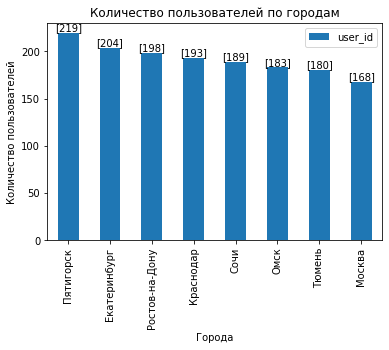

In [27]:
# строим график:
pivot_users_city.plot(kind='bar')
plt.title('Количество пользователей по городам')
plt.xlabel('Города')
plt.ylabel('Количество пользователей')

for index, value in enumerate(pivot_users_city.values):  
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

**Промежуточный вывод:**\
Самым часто встречающимся городом является Пятигорск, далее идут Екатеринбург и Ростов-на-Дону.

3.2 Описание и визуализация соотношения пользователей с подпиской и без подписки.

In [28]:
# формируем сводную таблицу:
pivot_users_subscription = users.pivot_table(index='subscription_type', 
                                values='user_id',
                                aggfunc='count')

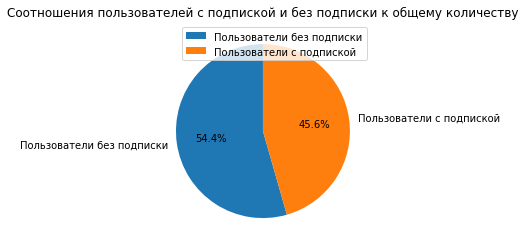

In [29]:
# строим диаграмму:
pivot_users_subscription.plot(kind='pie',
                              subplots=True,
                              autopct='%1.1f%%',
                              labels=('Пользователи без подписки', 'Пользователи с подпиской'),
                              startangle=90)
plt.title('Соотношения пользователей с подпиской и без подписки к общему количеству')
plt.ylabel('')
plt.show()

**Промежуточный вывод:**\
Как показывает диаграмма, пользователей без подписки больше, чем пользователей с подпиской. Их соотношение в % равно 54,1% и 45,9% соответственно.

3.3 Описание и визуализация возраста пользователей.

In [30]:
# формируем сводную таблицу:
pivot_users = users.pivot_table(index='age', values='user_id',aggfunc='count')\
                   .sort_values(by='age')

In [31]:
# описание столбца age датафрейма users:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

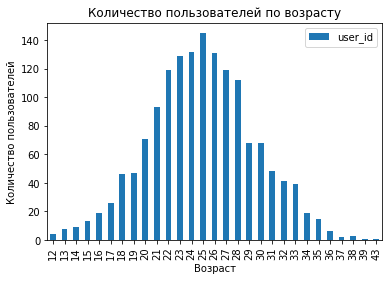

In [32]:
# строим график:
pivot_users.plot(kind='bar')
plt.title('Количество пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

**Промежуточный вывод:**\
Наибольшее количество пользователей в возрасте 22-28 лет. Средний возраст пользователя примерно 25 лет. Есть пользователи возраста 12-17 лет, вероятнее всего, использование сервиса услуг аренды самокатов в таком возрасте является нарушением действующих правил аренды самокатов.

3.4 Описание и визуализация расстояния, которое пользователь преодолел за одну поездку.

In [33]:
# описание столбца distance датафрейма rides:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

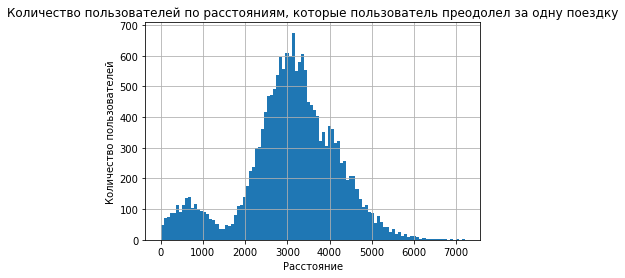

In [34]:
# строим график:
rides['distance'].hist(bins=100)
plt.title('Количество пользователей по расстояниям, которые пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество пользователей')
plt.show()

**Промежуточный вывод:**\
Среднее растояние, которое пользователь преодолевает за одну поездку, составляет 3 071 метр.

3.5 Описание и визуализация продолжительности поездок.

In [35]:
# описание столбца duration датафрейма rides:
rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

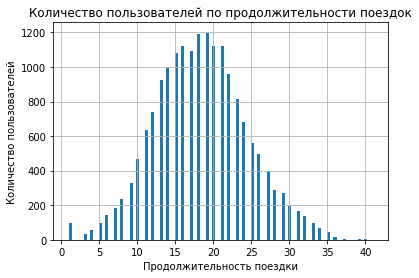

In [36]:
# строим график:
rides['duration'].hist(bins=100)
plt.title('Количество пользователей по продолжительности поездок')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество пользователей')
plt.show()

**Промежуточный вывод:**\
Средняя продолжительность поездки составляет 17 мин.

**Вывод:**
1. Самым часто встречающимся городом является Пятигорск, далее идут Екатеринбург и Ростов-на-Дону.
2. Как показывает диаграмма, пользователей без подписки больше, чем пользователей с подпиской. Их соотношение в % равно 54,1% и 45,9% соответственно.
3. Наибольшее количество пользователей в возрасте 22-28 лет. Средний возраст пользователя примерно 25 лет.
4. Среднее растояние, которое пользователь преодолевает за одну поездку, составляет 3071м.
5. Средняя продолжительность поездки составляет 17 мин.

#### Шаг 4. Объединение данных

4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм

In [37]:
# объединение данных о пользователях и поездках в один датафрейм 
# методом merge():
data = users.merge(rides, on='user_id')

In [38]:
# объединение данных о пользователях, поездках и подписках в один датафрейм
# методом merge():
data = data.merge(subscriptions, on='subscription_type')

In [39]:
# поиск дубликатов в объединенном датафрейме:
data.duplicated().sum()

0

In [40]:
# просмотр основной информации об объединенном датафрейме:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [41]:
# поиск дубликатов в объединенном датафрейме:
data.duplicated().sum()

0

In [42]:
# выводим первые строки объединенного датафрейма:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,6,0,199


4.2 Создание датафреймов c данными о пользователях без подписки и с данными о пользователях с подпиской из датафрейма, созданного на этапе 4.1.

In [43]:
# создание датафрейма c данными о пользователях без подписки:
data_free = data[data['subscription_type'] == 'free']

In [44]:
# выводим первые строки датафрейма data_free:
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18.0,2021-02-14,2,8,50,0


In [45]:
# создание датафрейма c данными о пользователях с подпиской:
data_ultra = data[data['subscription_type'] == 'ultra']

In [46]:
# выводим первые строки датафрейма data_ultra:
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,6,0,199


4.3 Визуализизация информации о расстоянии и времени поездок для пользователей категорий без подписки и с подпиской.

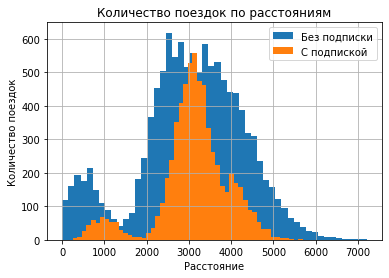

In [47]:
# строим графики расстояний поездок пользователей без подписки и с подпиской:
data_free['distance'].hist(bins=50, label='Без подписки')
data_ultra['distance'].hist(bins=50, label='С подпиской')
plt.title('Количество поездок по расстояниям')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [48]:
# описание столбца distance датафрейма data_free:
data_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [49]:
# строим график расстояний поездок пользователей с подпиской:
# data_ultra['distance'].hist();
#plt.xlabel('distance');

In [50]:
# описание столбца distance датафрейма data_ultra:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

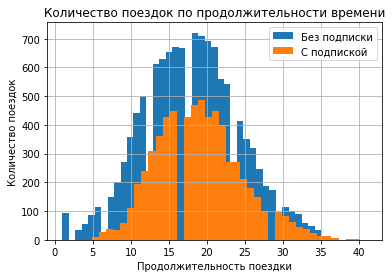

In [51]:
# строим графики времени поездок пользователей без подписки и с подпиской:
data_free['duration'].hist(bins=40, label='Без подписки')
data_ultra['duration'].hist(bins=40, label='С подпиской')
plt.title('Количество поездок по продолжительности времени')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [52]:
# описание столбца duration датафрейма data_free:
data_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [54]:
# описание столбца duration датафрейма data_ultra:
data_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

**Вывод:**
1. Объединение данных о пользователях, поездках и подписках в один датафрейм проведено успешно. Количество строк объединенной таблицы соответствует количеству строк в таблице с максимальным количеством строк, 18 068 в таблице rides. Явные дубликаты отсутствуют.
2. Создали два датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской из датафрейма, созданного на предыдущем этапе.
3. Как показывают графики и описание расстояний поездок пользователей, среднее значение расстояний поездок пользователей с подпиской составляет 3 115 м, что выше среднего значения расстояний поездок пользователей без подписки, которое составило 3 045 м. Таким образом, при наличии подписки пользователи проезжают в среднем большее расстояние.\
Как показывают графики и описание времени поездок пользователей, среднее значение продолжительности поездок пользователей с подпиской составляет 18 мин., что выше среднего значения продолжительности поездок пользователей без подписки, которое составило 17 мин. Таким образом, средняя продолжительность поездки пользователей с подпиской больше, чем пользователей без подписки.

#### Шаг 5. Подсчёт выручки

5.1 Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: поиск суммарного расстояния, количества поездок и суммарного времени для каждого пользователя за каждый месяц.

In [55]:
# создание таблицы с суммарным расстоянием, количеством поездок и 
# суммарным временем для каждого пользователя за каждый месяц:
data_month = data.groupby(['user_id', 'month']).agg(
    distance = ('distance', 'sum'),
    count = ('distance', 'count'),
    duration = ('duration', 'sum'),
    start_ride_price = ('start_ride_price', 'mean'),
    minute_price = ('minute_price', 'mean'),
    subscription_fee = ('subscription_fee', 'mean')
).reset_index()

In [56]:
# проверяем наличие пропущенных значений:
data_month.isna().sum()

user_id             0
month               0
distance            0
count               0
duration            0
start_ride_price    0
minute_price        0
subscription_fee    0
dtype: int64

In [57]:
# просмотр первых строк таблицы:
data_month.head()

,user_id,month,distance,count,duration,start_ride_price,minute_price,subscription_fee
0,1,1,7027.51,2,42.0,0,6,199
1,1,4,754.16,1,7.0,0,6,199
2,1,8,6723.47,2,46.0,0,6,199
3,1,10,5809.91,2,32.0,0,6,199
4,1,11,7003.50,3,56.0,0,6,199


5.2 Добавление в созданную в п. 5.1 таблицу столбца с помесячной выручкой, которую принёс каждый пользователь.

In [59]:
# функция для расчета выручки:
def calculate_revenue(row):
    revenue = (row['start_ride_price']*row['count'] + \
               row['minute_price']*row['duration'] + \
               row['subscription_fee'])
    return revenue

In [60]:
# добавление в датафрейм data_month столбца с помесячной выручкой,
# которую принёс каждый пользователь:
data_month['revenue'] = data_month.apply(calculate_revenue, axis=1)

In [61]:
# просмотр первых строк таблицы:
data_month.head()

,user_id,month,distance,count,duration,start_ride_price,minute_price,subscription_fee,revenue
0,1,1,7027.51,2,42.0,0,6,199,451.0
1,1,4,754.16,1,7.0,0,6,199,241.0
2,1,8,6723.47,2,46.0,0,6,199,475.0
3,1,10,5809.91,2,32.0,0,6,199,391.0
4,1,11,7003.50,3,56.0,0,6,199,535.0


**Вывод:**
1. Cоздали таблицу с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц и просмотрели ее первые строки.
2. Добавили в созданную в предыдущем пункте таблицу столбец с помесячной выручкой, которую принёс каждый пользователь.

#### Шаг 6. Проверка гипотез

6.1 Проверка тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки.

Выдвигаем гипотезы:\
Н0 - Пользователи с подпиской в среднем тратят столько же времени на поездки, сколько и пользователи без подписки.\
Н1 - Пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки.

Выдвигаем гипотезы:\
Н0 - Средние значения времени поездок пользователей с подпиской и без подписки равны. \
Н1 - Средние значения времени поездок пользователей с подпиской больше средних значений времени поездок пользователей без подписки.

In [62]:
# проверяем гипотезы методом st.ttest_ind:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data_ultra['duration'],
                       data_free['duration'],
                       alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


In [63]:
# среднее значение времени поездок пользователей с подпиской:
data_ultra['duration'].mean()

19.037692307692307

In [64]:
# среднее значения времени поездок пользователей без поездки:
data_free['duration'].mean()

17.890992392807746

**Вывод теста гипотезы:**\
Нулевая гипотеза отвергнута. Есть основания утверждать, что средние значения времени поездок пользователей с подпиской больше средних значений времени поездок пользователей без подписки, при установленном уровне статистической значимости 5%.

6.2 Проверка можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров - оптимальное расстояние с точки зрения износа самоката.

Выдвигаем гипотезы:\
Н0 - Среднее расстояние поездок с подпиской равно оптимальному расстоянию 3130 метров.\
Н1 - Среднее расстояние поездок с подпиской больше оптимального расстояния 3130 метров.

In [65]:
# проверяем гипотезы методом st.ttest_1samp:
distance = 3130 # оптимальное расстояние
alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    data_ultra['distance'], 
    distance,
    alternative='greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


**Вывод теста гипотезы:**\
Нулевую гипотезу не получилось отвергнуть. Есть основания утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное расстояние 3130 метров при установленном уровне статистической значимости 5%.

6.3 Проверка будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Выдвигаем гипотезы:\
Н0 - Помесячная средняя выручка от пользователей с подпиской равна помесячной средней выручке от пользователей без подписки.\
Н1 - Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки.

In [66]:
# проверяем гипотезы методом st.ttest_ind:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data_month[data_month['subscription_fee'] > 0]['revenue'],
                       data_month[data_month['subscription_fee'] == 0]['revenue'],
                       alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод теста гипотезы:**\
Нулевая гипотеза отвергнута. Есть основания утверждать, что помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки при установленном уровне статистической значимости 5%.

6.4 Рассмотрим ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Команда обновила сервера и хочет проверить, снизилось ли количество обращений в техподдержку.\
Выборки в этом случае будут зависимыми, иначе - парными. Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В данной ситуации это пара измерений для каждого пользователя - до и после обновления сервера, а именно, количество обращений до и после обновления.\
Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок применим метод scipy.stats.ttest_rel().\
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.

**Вывод:**
1. Нулевая гипотеза отвергнута. Есть основания утверждать, что средние значения времени поездок пользователей с подпиской больше средних значений времени поездок пользователей без подписки, при установленном уровне статистической значимости 5%.
2. Нулевую гипотезу не получилось отвергнуть. Есть основания утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное расстояние 3130 метров при установленном уровне статистической значимости 5%. 
3. Нулевая гипотеза отвергнута. Есть основания утверждать, что помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки при установленном уровне статистической значимости 5%.
4. Чтобы проверить, снизилось ли количество обращений в техподдержку, используем метод scipy.stats.ttest_rel().\
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения. 
В данной ситуации это пара измерений для каждого пользователя - до и после обновления сервера, а именно, количество обращений до и после обновления.\
При тестировании будем использовать параметр alternative='less'.\
Гипотеза является односторонней, поскольку нас интересует только снижение обращений.

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

Необходимо разослать минимум 1161 промокодов,чтобы вероятность не выполнить план была меньше 5.0%.


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


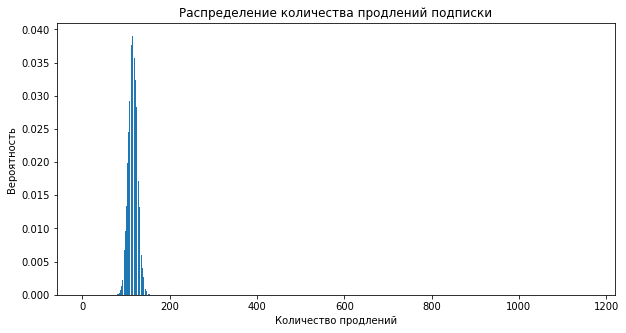

In [67]:
p = 0.1  # вероятность, что клиент продлит подписку  
k = 100   # необходимое количество продлений  
alpha = 0.05  # уровень значимости (вероятность невыполнения плана)  

# находим минимальное количество промокодов  
N = 1000  # начальное значение для N  

while binom.cdf(k - 1, N, p) > alpha:  
    N += 1    
print(f'Необходимо разослать минимум {N} промокодов,\
чтобы вероятность не выполнить план была меньше {alpha * 100:.1f}%.')  

# расчет математического ожидания и стандартного отклонения
# для нормального распределения:  
mu = N * p  
sigma = (N * p * (1 - p)) ** 0.5  

# значения для графика:  
x = np.arange(0, N + 1)  
y = binom.pmf(x, N, p)  

# строим график:  
plt.figure(figsize=(10, 5))  
plt.bar(x, y) 
plt.title('Распределение количества продлений подписки')
plt.xlabel('Количество продлений')  
plt.ylabel('Вероятность')     
plt.show() 

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность открытия сообщений: 0.15371708296369768


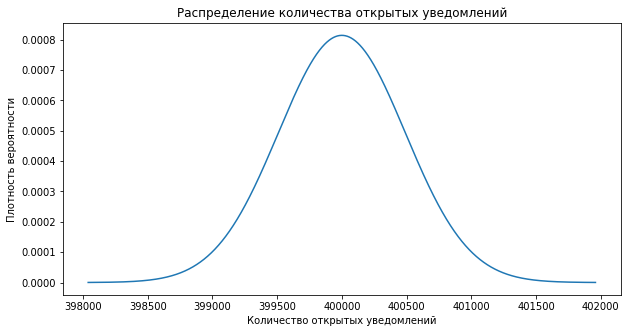

In [68]:
n = 1000000  # общее количество отправленных уведомлений  
p = 0.4      # вероятность того, что клиент откроет уведомление  
k = 399500    # количество открытых уведомлений  

# рассчитаем матожидание и стандартное отклонение:  
mu = n * p  # матожидание  
sigma = (n * p * (1 - p)) ** 0.5  # стандартное отклонение  

# зададим нормальное распределение:   
distr = st.norm(mu, sigma)  

# вычислим вероятность того, что уведомление откроют не более 399500 пользователей  
result = distr.cdf(k)  
print('Вероятность открытия сообщений:', result)  

# значения для графика:
x = np.arange(mu - 4 * sigma, mu + 4 * sigma, 1)
y = st.norm.pdf(x, mu, sigma)

# строим график: 
plt.figure(figsize=(10, 5))  
plt.plot(x, y)   
plt.title('Распределение количества открытых уведомлений')
plt.xlabel('Количество открытых уведомлений')  
plt.ylabel('Плотность вероятности')    
plt.show() 

**Вывод:**
1. Необходимо разослать как минимум 1161 промокод, чтобы вероятность не выполнить план была примерно 5 %.
2. Если разослать 1 млн. уведомлений, то вероятность того, что уведомление откроет не более 399,5 тыс. пользователей составит 15,37%.

**Общий вывод:**\
Исходя из проведенного исследования сервиса аренды самокатов GoFast, можно сделать следующие выводы: 
1. Загрузка данных.

  В датафрейме users 1565 записей, в датафреме rides 18 068 записей, в датафрейме subscriptions 2 записи.


2. Предобработка данных.
- Привели столбец date в датафрейме rides к типу даты pandas.
- Создали новый столбец с номером месяца на основе столбца date.
- Пропусков в данных нет, все данные заполнены.\
Однако, в датафрейме users найден 31 дубликат. Удаляем их методом drop_duplicates().
Округлили данные в столбце distance в датафрейме rides до 2 знаков.\
Округлили каждое значение в столбце duration с помощью метода np.ceil.
3. Исследовательский анализ данных.
- Самым часто встречающимся городом является Пятигорск, далее идут Екатеринбург и Ростов-на-Дону.
- Как показывает диаграмма, пользователей без подписки больше, чем пользователей с подпиской. Их соотношение в % равно 54,1% и 45,9% соответственно.
- Наибольшее количество пользователей в возрасте 22-28 лет. Средний возраст пользователя примерно 25 лет.
- Среднее растояние, которое пользователь преодолевает за одну поездку, составляет 3071м.
- Средняя продолжительность поездки составляет 17 мин.
4. Объединение данных.
- Объединение данных о пользователях, поездках и подписках в один датафрейм проведено успешно. Количество строк объединенной таблицы соответствует количеству строк в таблице с максимальным количеством строк, 18 068 в таблице rides. Явные дубликаты отсутствуют.
- Создали два датафрейма c данными о пользователях без подписки и с данными о пользователях с подпиской из датафрейма, созданного на предыдущем этапе.
- Как показывают графики и описание расстояний поездок пользователей, среднее значение расстояний поездок пользователей с подпиской составляет 3 115 м, что выше среднего значения расстояний поездок пользователей без подписки, которое составило 3 045 м. Таким образом, при наличии подписки пользователи проезжают в среднем большее расстояние.\
Как показывают графики и описание времени поездок пользователей, среднее значение продолжительности поездок пользователей с подпиской составляет 18 мин., что выше среднего значения продолжительности поездок пользователей без подписки, которое составило 17 мин. Таким образом, средняя продолжительность поездки пользователей с подпиской больше, чем пользователей без подписки.
5. Подсчёт выручки.
- Cоздали таблицу с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц и просмотрели ее первые строки.
- Добавили в созданную в предыдущем пункте таблицу столбец с помесячной выручкой, которую принёс каждый пользователь.
6. Проверка гипотез.
- Нулевая гипотеза отвергнута. Есть основания утверждать, что средние значения времени поездок пользователей с подпиской больше средних значений времени поездок пользователей без подписки, при установленном уровне статистической значимости 5%.
- Нулевую гипотезу не получилось отвергнуть. Есть основания утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное расстояние 3130 метров при установленном уровне статистической значимости 5%. 
- Нулевая гипотеза отвергнута. Есть основания утверждать, что помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки при установленном уровне статистической значимости 5%.
- Чтобы проверить, снизилось ли количество обращений в техподдержку, используем метод scipy.stats.ttest_rel().\
Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения. 
В данной ситуации это пара измерений для каждого пользователя - до и после обновления сервера, а именно, количество обращений до и после обновления. При тестировании будем использовать параметр alternative='less'. Гипотеза является односторонней, поскольку нас интересует только снижение обращений.
7. Распределения.
- Необходимо разослать как минимум 1161 промокод, чтобы вероятность не выполнить план была примерно 5 %.
- Если разослать 1 млн. уведомлений, то вероятность того, что уведомление откроет не более 399,5 тыс. пользователей составит 15,37%.